In [1]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant

from codes.gate_design import gate_coords
from codes.constants import scale
import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index
from codes.utils import order_wavefunctions

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
from scipy.optimize import minimize, minimize_scalar

In [3]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 1.0}}},
    {"gate": {"channel_width": 13.0, 'angle': np.pi/6, 'gap': 2}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [4]:
system = trijunction.Trijunction(config, optimize_phase_pairs=['left-right'])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:30<00:00,  2.33s/it]


In [5]:
sys.path

1.1620498115754614

In [7]:
pair = 'left-right'
voltages = parameters.pair_voltages()

In [8]:
zero_potential = dict(
    zip(
        ta.array(system.site_coords[:, [0, 1]] - system.offset),
        np.zeros(len(system.site_coords)),
    )
)

In [9]:
kwant_args = list(system.optimiser_arguments().values())
kwant_args[-1] = kwant_args[-1][order_wavefunctions(pair)]

In [71]:
x = [-1.0e-3, -1.0e-3, -5.0e-3, 3e-3]
voltages = parameters.voltage_dict(x)

In [72]:
params = parameters.junction_parameters()
params.update(voltages)
params.update(potential=zero_potential)

In [73]:
opt_args = tuple([pair, params, kwant_args, 0.0])

[-20.5   0. ]
[20.5  0. ]
[ 0.  76.5]
[-20.  24.]
[-5.5  7.5]
[5.5 7.5]
[20. 24.]
[-16.5  57.5]
[16.5 57.5]


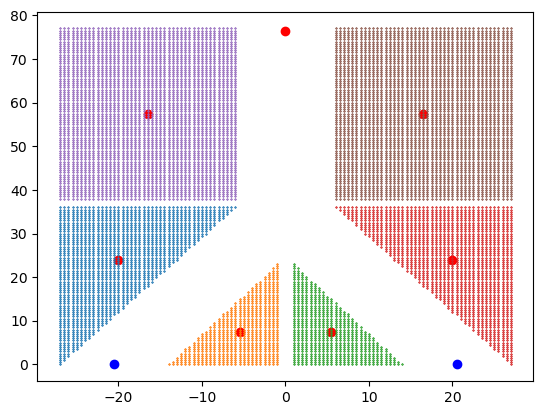

In [74]:
kwant_sites = np.array([site.pos for site in system.trijunction.sites])/scale

dep_index, acc_index = dep_acc_index(
            system.poisson_system,
            kwant_sites,
            system.site_indices,
            system.nw_centers,
            pair,
            True
        )
params.update({'dep_index': dep_index})
params.update({'acc_index': acc_index})


In [75]:
step_size = 1e-4
opt_args = tuple((pair, params, kwant_args, 0.0, step_size))
# optimization.loss(x, *opt_args)

In [76]:
import codes.optimization
import importlib
importlib.reload(codes.optimization)

<module 'codes.optimization' from '/home/tinkerer/trijunction-design/analysis/codes/optimization.py'>

In [ ]:
sol1 = minimize(
            codes.optimization.loss,
            x,
            args=opt_args,
            method="trust-constr",
            # jac=codes.optimization.jacobian,
            options={
                "verbose":2,
                "initial_tr_radius":1e-3,
                "gtol":1e0
            },
        )

[-0.001 -0.001 -0.005  0.003]
0.18215093066514423 0.0010457858719185053
[-0.00100001 -0.001      -0.005       0.003     ]
0.18215840761036037 0.001045783097530719
[-0.001      -0.00100001 -0.005       0.003     ]
0.18215840761036295 0.001045774307988682
[-0.001      -0.001      -0.00500001  0.003     ]
0.18215182525535467 0.001045784715752685
[-0.001      -0.001      -0.005       0.00300001]
0.18214833773536593 0.0010457922068712012
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | -1.7478e-01 | 1.00e-03 | 5.04e+02 | 0.00e+00 |
[-0.00168395 -0.00168475 -0.00508268  0.00276232]
0.3247522534559975 0.0006490667788936922
[-0.00168397 -0.00168475 -0.00508268  0.00276232]
0.32476151473005255 0.0006490228077200424
[-0.00168395 -0.00168477 -0.00508268  0.00276232]
0.324761513363974 0.0006490611065385203
[-0.00168395 -0.00168475 -0.0050827   0.00276232]
0.3247548102473996 0.

In [161]:
objective = codes.optimization.loss



In [162]:
%%time
from optimization import jacobian
jacobian(x, *opt_args)

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1
VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1
VoronoiMesh version 0.1
DiscretePoisson version 0.3
VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1
VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1
CPU times: user 7.66 s, sys: 1.23 s, total: 8.88 s
Wall time: 18 s


array([ 2.23078065e-06,  2.23078093e-06, -4.63471130e-08,  3.44680335e-06])

In [163]:
%%time

gradient = lambda x: approx_fprime(x, codes.optimization.loss, step_size, *opt_args)
gradient(x)

CPU times: user 32 s, sys: 9.75 s, total: 41.8 s
Wall time: 38.9 s


array([ 2.23078065e-06,  2.23078093e-06, -4.63471128e-08,  3.44680335e-06])

### Gradient descent

In [25]:
from scipy.optimize import approx_fprime

In [29]:
def ArmijoLineSearch(f, fargs, xk, pk, gfk, phi0, alpha0, rho=0.5, c1=1e-4):
    """
    Parameters
    --------------------
    f : callable
        Function to be minimized.
    xk : array
        Current point.
    pk : array
        Search direction.
    gfk : array
        Gradient of `f` at point `xk`.
    phi0 : float
        Value of `f` at point `xk`.
    alpha0 : scalar
        Value of `alpha` at the start of the optimization.
    rho : float, optional
        Value of alpha shrinkage factor.
    c1 : float, optional
        Value to control stopping criterion.
    
    Returns
    --------------------
    alpha : scalar
        Value of `alpha` at the end of the optimization.
    phi : float
        Value of `f` at the new point `x_{k+1}`.
    """
    derphi0 = np.dot(gfk, pk)
    phi_a0 = f(xk + alpha0*pk, *fargs)
    
    while not phi_a0 <= phi0 + c1*alpha0*derphi0:
        alpha0 = alpha0 * rho
        phi_a0 = f(xk + alpha0*pk, *fargs)
        
        print(phi_a0)
    
    return alpha0, phi_a0

In [30]:
def gradient_descent(gradient, initial, learn_rate=0.5, 
                     beta1=0.9, beta2=0.999,
                     tolerance=1e-6, epsilon = 1e-8, n_iter=50):
    vector = initial
    diff, A, F = 0, 0, 0
    
    diff_cost = []
    
    
    g = gradient(vector)
    cost = codes.optimization.loss(vector, *opt_args)
    
    for i in range(n_iter):
        
        
        print(g)
        # https://machinelearningmastery.com/adam-optimization-from-scratch/
        # Adam's gradient
        # A = beta1 * A + (1 - beta1) * (g**2)
        # F = beta2 * F + (1 - beta2) * (g)
        # Ahat = A / (1 - beta1**(i+1))
        # Fhat = F / (1 - beta2**(i+1))
        # # learn_rate *= (np.sqrt(1 - beta1**(i+1)) / (1 - beta2**(i+1)))
        # vector -= (learn_rate * Fhat)/(np.sqrt(Ahat) + epsilon)  # epsilon for better conditioning
        
        previous_cost = cost
        
        learn_rate, cost = ArmijoLineSearch(
            codes.optimization.loss,
            opt_args,
            vector,
            -g,
            g,
            cost,
            learn_rate          
        )
        
        # Vanilla gradient descent
        diff = -learn_rate * g
        
        # Momentum based learning
        # diff = decay_rate * diff - learn_rate * g
        
        # next step in the iteration
        vector += diff
        
        g = gradient(vector)
        
        print(vector)
        
        # if np.all(np.abs(diff) <= tolerance):
        #     break
        
        
        
        print(cost)
        
        diff_cost.append(np.abs(1 - previous_cost/cost))
        
        
        if i > 5:
            if np.all(np.array(diff_cost)[i-5:-1] < 1e-1):
                break
    
    return i, diff_cost, cost, vector



In [ ]:
import multiprocessing as mp
# Step 1: Init multiprocessing.Pool()
from pathos.multiprocessing import ProcessingPool as Pool

pool = Pool(mp.cpu_count())

# # Step 2: `pool.apply` the `howmany_within_range()`
# results = [pool.apply(howmany_within_range, args=(row, 4, 8)) for row in data]


In [384]:
%%time
finite_difference_jacobian(codes.optimization.loss, x, opt_args, 1e-3)

TypeError: call.work() missing 1 required positional argument: 'opt_args'

In [68]:
optimiser_args = system.optimiser_arguments()
params.update(parameters.voltage_dict(sol1.x))

linear_ham, numerical_hamiltonian = hamiltonian(system.trijunction, 
                                    optimiser_args['linear_terms'], 
                                    optimiser_args['kwant_params_fn'], 
                                    **params)

In [69]:
energies, wave_functions = eigsh(
                numerical_hamiltonian.tocsc(),
                6,
                sigma=0,
                return_eigenvectors=True,
)

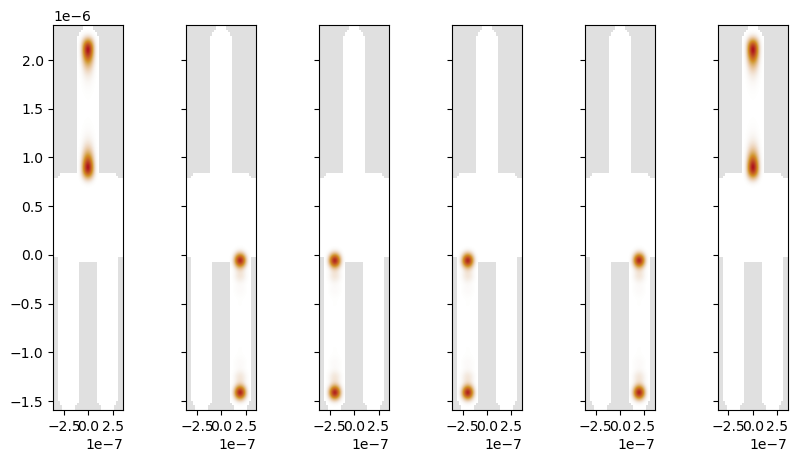

In [70]:
fig, ax = plt.subplots(1, 6, figsize = (10, 5), sharey= True)

density = kwant.operator.Density(system.trijunction, np.eye(4))
for i, vec in enumerate(wave_functions.T):
    kwant.plotter.density(system.trijunction, density(vec), ax = ax[i]);

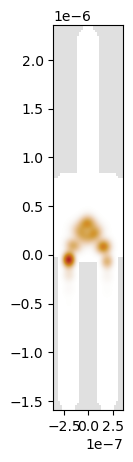

In [130]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5), sharey= True)

density = kwant.operator.Density(system.trijunction, np.eye(4))
for i, vec in enumerate(wave_functions.T[[0]]):
    kwant.plotter.density(system.trijunction, density(vec), ax = ax);

In [81]:
transformed_hamiltonian = svd_transformation(
    energies, wave_functions, system.mlwf[order_wavefunctions('left-right')]
)

desired = np.abs(transformed_hamiltonian[0, 1])
undesired = np.linalg.norm(transformed_hamiltonian[2:])

In [82]:
desired

5.287730948954797e-06

In [83]:
undesired

5.796575760775433e-06

In [73]:
-desired**2 + undesired**2

2.8103203688840985e-15

In [83]:
kwant_sites

(28778, 2)

In [85]:
system.site_coords.shape

(16895, 3)